# 金融分析和风险管理常用基础函数

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import scipy.stats as st
from scipy.stats import norm
import numpy.random as npr
from pylab import mpl

#以下二选一，解决‘负号’显示异常问题
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus']=False

#解决中文乱码问题，请用：to_csv(encoding='utf_8_sig')

In [2]:
#计算算术均值
def mean_a(r):
    return sum(r)/len(r)

#或者用lambda函数搞定
mean_a2=lambda r:sum(r)/len(r)

#计算几何均值
def mean_g(r):
    total=1
    for i in r:
        total=total*(1+i)
    return pow(total,1/len(r))-1

#正态分布N(mu,sigma)的概率密度函数PDF
def f(x,mu,sigma):
    return 1/(sigma*pow(2*np.pi,0.5))*np.exp(-0.5*((x-mu)/sigma)**2)
#标准正态分布N(0,1)的概率密度函数PDF
def f(x):
    return 1/pow(2*np.pi,0.5)*np.exp(-0.5*x**2)

In [3]:
#计算不同复利频次的终值函数
def fv(a,n,r,m):
    if m=='年':
        return a*(1+r)**n
    elif m=='半年':
        return a*(1+r/2)**(2*n)
    elif m=='季度':
        return a*(1+r/4)**(4*n)
    elif m=='月':
        return a*(1+r/12)**(12*n)
    elif m=='周':
        return a*(1+r/52)**(52*n)
    else:
        return a*(1+r/365)**(365*n)

#已知离散复利利率和复利频次，求等价连续复利
def Rc(Rm,m):
    return m*np.log(1+Rm/m)

#已知连续复利和复利频次，求等价的离散复利利率
def Rm(Rc,m):
    return m*(np.exp(Rc/m)-1)
 

 **债券相关基础函数:**



[0.023268 0.023538 0.026424 0.025411 0.028313]


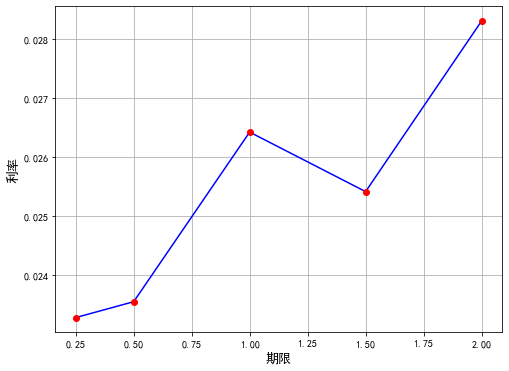

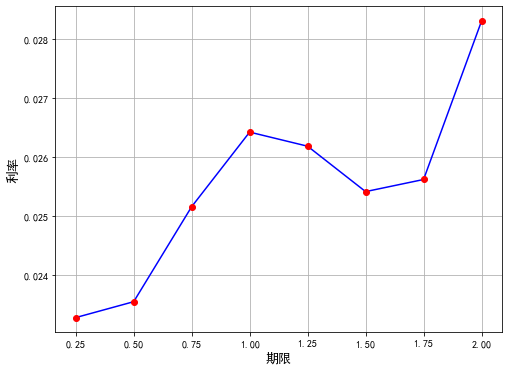

In [4]:

#计算债券价格：（票面利率，面值，期限，付息频次，YTM(连续复利))
def bond_price(c,M,t,m,y):
    coupon=[]
    for i in np.arange(1,m*t+1):
        coupon.append(np.exp(-y*i/m)*M*c/m)
    return np.sum(coupon)+np.exp(-y*t)*M

#计算YTM：（票面利率，面值，期限，付息频次，市场价格)
def ytm(c,M,t,m,p):
    def f(y):
        coupon=[]
        for i in np.arange(1,m*t+1):
            coupon.append(np.exp(-y*i/m)*M*c/m)
        return np.sum(coupon)+np.exp(-y*t)*M-p
    
    return sco.fsolve(f,0.1)


#计算利率期限结构
def f(r):
    r1,r2,r3,r4,r5=r
    p1=99.42
    p2=98.83
    p3=100.09
    p4=101.32   
    p5=99.39
    par=100
    c3=0.0277
    c4=0.0346       
    c5=0.0253
    b1=par*np.exp(-r1*0.25)-p1
    b2=par*np.exp(-r2*0.5)-p2
    b3=par*(1+c3)*np.exp(-r3)-p3
    b4=par*(0.5*c4*np.exp(-r2*0.5)+0.5*c4*np.exp(-r3)+(1+0.5*c4)*np.exp(-r4*1.5))-p4
    b5=par*(0.5*c5*np.exp(-r2*0.5)+0.5*c5*np.exp(-r3)+0.5*c5*np.exp(-r4*1.5)+(1+0.5*c5)*np.exp(-r5*2))-p5
    return np.array([b1,b2,b3,b4,b5])

zero_rate=sco.fsolve(f,[0.1,0.1,0.1,0.1,0.1])
print(np.round(zero_rate,6))

t=np.array([0.25,0.5,1,1.5,2])
plt.figure(figsize=(8,6))
plt.plot(t,zero_rate,'b-')
plt.plot(t,zero_rate,'ro')
plt.xlabel('期限',fontsize=13)
plt.ylabel('利率',fontsize=13)
plt.grid()


#插值法计算缺省的零息利率
import scipy.interpolate as si
func=si.interp1d(t,zero_rate,kind='cubic')
t_new=np.array([0.25,0.5,0.75,1,1.25,1.5,1.75,2])
zero_rate_new=func(t_new)

plt.figure(figsize=(8,6))
plt.plot(t_new,zero_rate_new,'b-')
plt.plot(t_new,zero_rate_new,'ro')
plt.xlabel('期限',fontsize=13)
plt.ylabel('利率',fontsize=13)
plt.grid()


#根据不同期限的零息利率计算债券价格：（债券每期的现金流array,现金流期限array,各期限的零息利率array)
def bond_value(c,t,y):
    cashflow=[]
    for i in np.arange(len(c)):
        cashflow.append(c[i]*np.exp(-y[i]*t[i]))
    return np.sum(cashflow)

#计算远期利率（短：r1,t1;长：r2,t2)
def Rf(r1,r2,t1,t2):
    return r2+(r2-r1)*t1/(t2-t1)


#计算FRA（Rk固定利率，Rm：t1时刻的参考利率，L：本金，position:long/short,when:t1/t2）
def FRA(Rk,Rm,L,t1,t2,position,when):
    if position=='long':
        if when==t1:
            return ((Rm-Rk)*(t2-t1)*L)/(1+(t2-t1)*Rm)
        else:
            return (Rm-Rk)*(t2-t1)*L
    else:
        if when==t1:
            return ((Rk-Rm)*(t2-t1)*L)/(1+(t2-t1)*Rm)
        else:
            return (Rk-Rm)*(t2-t1)*L 


#计算0时刻FRA的价值(定价):（Rk固定利率，Rf：t1-t2的远期利率，R：t2的无风险利率，L：本金,position:long/short)
def V_FRA(Rk,Rf,R,L,t1,t2,position):
    if position=='long':
        return L*(Rf-Rk)*(t2-t1)*np.exp(-R*t2)
    else:
        return L*(Rk-Rf)*(t2-t1)*np.exp(-R*t2)

    
#麦考利久期：用连续复利的YTM折现
#计算麦考利久期（c:cashflow array,y:YTM(连续复利),t:cashflow对应的时刻 array）
def MacD(c,y,t):
    n=len(t)
    cashflow=[]
    weight=[]
    for i in np.arange(n):
        cashflow.append(c[i]*np.exp(-y*t[i]))   #每期现金流的现值
    for i in np.arange(n):
        weight.append(cashflow[i]/sum(cashflow))  #权重
        
    duration=np.sum(weight*t)
    return duration


#计算修正久期：（c:cashflow array,y:YTM(复利频次m次),t:cashflow对应的时刻 array）
def ModD(c,y,m,t):
    n=len(t)
    cashflow=[]
    weight=[]
    Rc=m*np.log(1+y/m)
    
    for i in np.arange(n):
        cashflow.append(c[i]*np.exp(-Rc*t[i]))   #每期现金流的现值
    for i in np.arange(n):
        weight.append(cashflow[i]/sum(cashflow))  #权重
    
    duration=np.sum(weight*t)
    return duration/(1+y/m)


#计算美元久期:（c:cashflow array,y:YTM(复利频次m次),t:cashflow对应的时刻 array）
def DollD(c,y,m,t):
    n=len(t)
    cashflow=[]
    weight=[]
    Rc=m*np.log(1+y/m)
    
    for i in np.arange(n):
        cashflow.append(c[i]*np.exp(-Rc*t[i]))   #每期现金流的现值
        
    bond_price=sum(cashflow)
    
    for i in np.arange(n):
        weight.append(cashflow[i]/bond_price) #权重
        
    duration=np.sum(weight*t)/(1+y/m)   #修正久期
    
    return bond_price*duration


#计算凸度：（c:cashflow array,y:YTM(连续复利),t:cashflow对应的时刻 array）
def con(c,y,t):
    n=len(t)
    cashflow=[]
    weight=[]
    for i in np.arange(n):
        cashflow.append(c[i]*np.exp(-y*t[i]))   #每期现金流的现值    
    bond_price=sum(cashflow)
    for i in np.arange(n):
        weight.append(cashflow[i]/bond_price)  #权重
        
    convexity=np.sum(weight*t**2)
    return convexity

**CAPM模型和有效前沿:**

In [14]:
#利用“构建投资组合的五只股票数据（2016-2018）.xlsx”中的数据计算投资组合的预期收益率和年化波动率
data=pd.read_excel('数据/构建投资组合的五只股票数据（2016-2018）.xlsx',sheet_name="Sheet1",
                   header=0,index_col=0)
#data.head()



In [15]:
#计算收益率
R=np.log(data/data.shift(1))
R=R.dropna()
#R.describe()

In [16]:
#计算每只股票的平均收益率、波动率以及协方差
#年化处理
R_mean=R.mean()*252
R_vol=R.std()*np.sqrt(252)
R_cov=R.cov()*252
R_corr=R.corr()

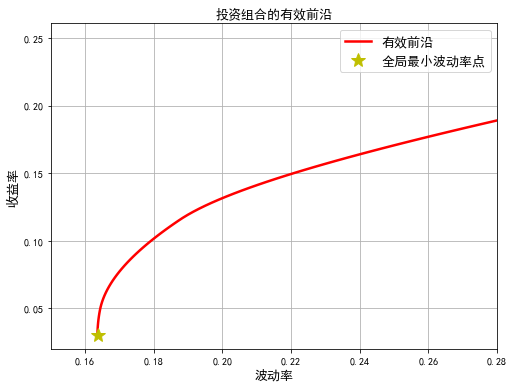

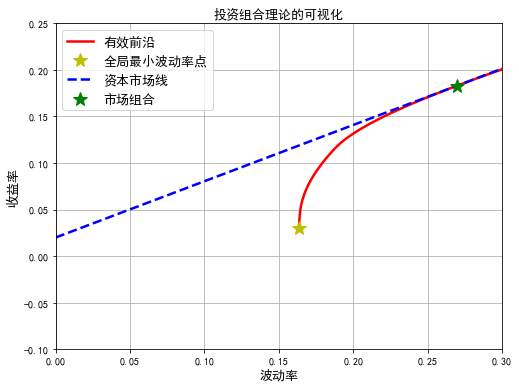

In [17]:
#计算全局最小波动率点  
def f(w):
    w=np.array(w)
    Rp_opt=np.sum(w*R_mean)
    Vp_opt=np.sqrt(np.dot(np.dot(w,R_cov),w.T))
    return np.array([Rp_opt,Vp_opt])

def Vmin_f(w):
    return f(w)[1]

cons_vmin=cons=({'type':'eq','fun':lambda x:np.sum(x)-1})   #设置权重和等于1的约束条件
bnds=tuple((0,1) for x in range(len(R_mean)))

result_vmin=sco.minimize(Vmin_f,len(R_mean)*[1/len(R_mean),],method='SLSQP',bounds=bnds,constraints=cons_vmin)
Rp_vmin=np.sum(R_mean*result_vmin['x'])
Vp_vmin=result_vmin['fun']

#有效前沿
Rp_target=np.linspace(Rp_vmin,0.25,100)  #生成全局最小波动率点以上的目标收益率数组
Vp_target=[]
for r in Rp_target:
    cons_new=({'type':'eq','fun':lambda x:np.sum(x)-1},{'type':'eq','fun':lambda x:f(x)[0]-r})
    result_new=sco.minimize(Vmin_f,len(R_mean)*[1/len(R_mean),],method='SLSQP',bounds=bnds,constraints=cons_new)
    Vp_target.append(result_new['fun'])

plt.figure(figsize=(8,6))
#plt.scatter(Vp,Rp)
plt.plot(Vp_target,Rp_target,'r-',label='有效前沿',lw=2.5)
plt.plot(Vp_vmin,Rp_vmin,'y*',label='全局最小波动率点',markersize=14)
plt.xlabel('波动率',fontsize=13)
plt.ylabel('收益率',fontsize=13)
plt.xlim(0.15,0.28)
plt.title('投资组合的有效前沿',fontsize=13)
plt.legend(fontsize=13)
plt.grid()


#CML资本市场线
Rf=0.02
def F(w):
    w=np.array(w)
    Rp_opt=np.sum(w*R_mean)
    Vp_opt=np.sqrt(np.dot(np.dot(w,R_cov),w.T))
    SR=(Rp_opt-Rf)/Vp_opt
    return np.array([Rp_opt,Vp_opt,SR])

def SRmin_F(w):
    return -F(w)[2]

cons_SR=({'type':'eq','fun':lambda x:np.sum(x)-1})
result_SR=sco.minimize(SRmin_F,len(R_mean)*[1/len(R_mean),],method='SLSQP',bounds=bnds,constraints=cons_SR)

slope=-result_SR['fun']
Rm=np.sum(R_mean*result_SR['x'])
Vm=(Rm-Rf)/slope

Rp_cml=np.linspace(0.02,0.25)
Vp_cml=(Rp_cml-Rf)/slope

plt.figure(figsize=(8,6))
#plt.scatter(Vp,Rp)
plt.plot(Vp_target,Rp_target,'r-',label='有效前沿',lw=2.5)
plt.plot(Vp_vmin,Rp_vmin,'y*',label='全局最小波动率点',markersize=14)
plt.plot(Vp_cml,Rp_cml,'b--',label='资本市场线',lw=2.5)
plt.plot(Vm,Rm,'g*',label='市场组合',markersize=14)
plt.xlabel('波动率',fontsize=13)
plt.ylabel('收益率',fontsize=13)
plt.xlim(0,0.3)
plt.ylim(-0.1,0.25)
plt.title('投资组合理论的可视化',fontsize=13)
plt.legend(fontsize=13)
plt.grid()


In [18]:
#用CAPM模型计算预期收益
def Ri_CAPM(beta,Rm,Rf):
    return Rf+beta*(Rm-Rf)

#用线性回归：Y=a+b*X计算个股的beta
#个股收益率R作为因变量Y,沪深300股指R_index作为自变量X

data_index=pd.read_excel('数据/沪深300指数（2016-2018年）.xlsx',sheet_name="Sheet1",header=0,index_col=0)
#data_index.head()


R_index=np.log(data_index/data_index.shift(1))
R_index=R_index.dropna()
#R_index.describe()

R_index_addcons=sm.add_constant(R_index) #给自变量X加一列常数项a

#计算R中各只股票的beta
for i in range(len(R_mean)):
    model=sm.OLS(R.iloc[:,i],R_index_addcons)   
    result=model.fit()
    result.summary()
    result.params
    print(R.columns[i],"贝塔值",round(result.params[1],4))
    


上海机场 贝塔值 0.7496
宝钢股份 贝塔值 1.0694
海通证券 贝塔值 1.1235
工商银行 贝塔值 0.5476
中国石油 贝塔值 0.6877


In [19]:
#计算各种风险调整收益率：

#计算SR夏普比率
def SR(Rp,Rf,Vp):
    return (Rp-Rf)/Vp

#计算下行标准差
def Vp_lower(R_fund,R_fund_mean):
    Vpl=np.zeros_like(R_fund_mean)
    for i in range(len(Vpl)):
        R_neg=R_fund.iloc[:,i][R_fund.iloc[:,i]<0] #截取负的收益率
        Vpl[i]=np.sqrt(252)*np.sqrt(np.sum(R_neg**2)/len(R_neg))
    return Vpl
    

#举例：计算4只基金收益率的下行标准差
fund=pd.read_excel('数据/四只开放式股票型基金的净值（2016-2018年）.xlsx',sheet_name="Sheet1",
                   header=0,index_col=0)
#fund.head()

R_fund=np.log(fund/fund.shift(1))
R_fund=R_fund.dropna()
#R_fund.describe()
R_fund_mean=R_fund.mean()*252

Vpl=np.zeros_like(R_fund_mean)
for i in range(len(Vpl)):
    R_neg=R_fund.iloc[:,i][R_fund.iloc[:,i]<0] #截取负的收益率
    Vpl[i]=np.sqrt(252)*np.sqrt(np.sum(R_neg**2)/len(R_neg))
    print(R_fund.columns[i],"收益率下行标准差",round(Vpl[i],4))
    
#计算SOR索提诺比率
def SOR(Rp,Rf,Vpl):
    return (Rp-Rf)/Vpl

#计算TR特雷诺比率
def TR(Rp,Rf,beta):
    return (Rp-Rf)/beta

#计算IR信息比率
def IR(Rp,Rb,TE):
    return (Rp-Rb)/TE    #TE=(Rp-Rb).std()*np.sqrt(252)

景顺长城优质成长基金 收益率下行标准差 0.1953
汇添富移动互联基金 收益率下行标准差 0.3231
华宝品质生活基金 收益率下行标准差 0.2415
中银新动力基金 收益率下行标准差 0.2706


**期货与期权：**

In [20]:
#计算套期保值（对冲）的最优期货合约分数
def N(h,Q_A,Q_F):
    return h*Q_A/Q_F


#按照不同的天数计算惯例求债券的应计利息:
#(par:面值；c：coupon rate；m：票息支付次数；t1,t2:非参考期间起止日期;t3,t4:参考期间起止日期（元组形式输入))
import datetime as dt
def AI(par,c,m,t1,t2,t3,t4,rule):    
    d1=dt.datetime(t2[0],t2[1],t2[2])-dt.datetime(t1[0],t1[1],t1[2])
    if rule=='actual/actual':
        d2=dt.datetime(t4[0],t4[1],t4[2])-dt.datetime(t3[0],t3[1],t3[2])
        interest=(d1.days/d2.days)*par*c/m
    elif rule=='actual/360':
        interest=(d1.days/360)*par*c
    else:
        interest=(d1.days/365)*par*c
    
    return interest
        
    
#转换因子CF的计算:
#(r:国债期货标的债券的票面利率;x:期货交割月到可交割债券下一付息月的月份数；
#n：交割后可交割债券的剩余付息次数；c：可交割债券的票面利率；m：可交割债券的付息频次)
def CF(r,x,n,c,m):
    A=1/pow(1+r/m,x*m/12)
    B=c/m+c/r+(1-c/r)/pow(1+r/m,n-1)
    D=c*(1-x*m/12)/m
    return A*B-D  

#计算最廉价交割成本:
#(b:可交割国债的报价（净价）;f:国债期货的价格；cf:转换因子)
def CTD_cost(b,f,cf):
    return b-f*cf

#计算基于久期对冲的国债期货数量:
#(Vf:1份（1手）国债期货的价值；P：被对冲的投资组合价值；Df：国债期货久期；Dp：投资组合的久期)
def N_TF(Vf,P,Df,Dp):
    return P*Dp/(Vf*Df)



#利用put-call parity计算call的价格
def call_parity(p,S,K,r,T):
    return p+S-K*np.exp(-r*T)

#计算put-call parity计算put的价格
def put_parity(c,S,K,r,T):
    return c+K*np.exp(-r*T)-S

         
#用BSM模型计算欧式期权价格
def call_BS(S,K,sigma,r,T):
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

def put_BS(S,K,sigma,r,T):
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)


#计算欧式期权的delta值
def delta(S,K,sigma,r,T,optype,positype):
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if optype=='call':
        if positype=='long':
            delta=norm.cdf(d1)
        else:
            delta=-norm.cdf(d1)
    else:
        if positype=='long':
            delta=norm.cdf(d1)-1
        else:
            delta=1-norm.cdf(d1)
    return delta

#计算欧式期权Gamma值
def gamma(S,K,sigma,r,T):
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return np.exp(-0.5*d1**2)/(S*sigma*np.sqrt(2*np.pi*T))


#计算欧式期权的Theta值
def theta(S,K,sigma,r,T,optype):
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    theta_call=-(S*sigma*np.exp(-0.5*d1**2))/(2*np.sqrt(2*np.pi*T))-r*K*np.exp(-r*T)*norm.cdf(d2)
    if optype=='call':
        theta=theta_call
    else:
        theta=theta_call+r*K*np.exp(-r*T)
    return theta

#计算欧式期权的vega值
def vega(S,K,sigma,r,T):
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return S*np.sqrt(T)*np.exp(-0.5*d1**2)/np.sqrt(2*np.pi)

#计算欧式期权的Rho值
def rho(S,K,sigma,r,T,optype):
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    if optype=='call':
        rho=K*T*np.exp(-r*T)*norm.cdf(d2)
    else:
        rho=-K*T*np.exp(-r*T)*norm.cdf(-d2)
    return rho

    
#用牛顿迭代法求隐波：
def impvol_call_newton(C,S,K,r,T):
    '''C:看涨期权市场价格'''
    def call_BS(S,K,sigma,r,T):
        d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2=d1-sigma*np.sqrt(T)
        return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)

    sigma0=0.2  #设定一个初始的波动率
    diff=C-call_BS(S,K,sigma0,r,T)
    i=0.0001  #设置一个精度标量
    while abs(diff)>0.0001:
        diff=C-call_BS(S,K,sigma0,r,T)
        if diff>0:
            sigma0 +=i
        else:
            sigma0 -=i
    return sigma0

def impvol_put_newton(P,S,K,r,T):
    '''P:看跌期权市场价格'''
    def put_BS(S,K,sigma,r,T):
        d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2=d1-sigma*np.sqrt(T)
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

    sigma0=0.2  #设定一个初始的波动率
    diff=P-put_BS(S,K,sigma0,r,T)
    i=0.0001  #设置一个精度标量
    while abs(diff)>0.0001:
        diff=P-put_BS(S,K,sigma0,r,T)
        if diff>0:
            sigma0 +=i
        else:
            sigma0 -=i
    return sigma0
        
    
#运用二分查找法计算隐波：
def impvol_call_binary(C,S,K,r,T):
    '''C:看涨期权市场价格'''
    def call_BS(S,K,sigma,r,T):
        d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2=d1-sigma*np.sqrt(T)
        return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2) 
    sigma_min=0.001 #设置初始最小波动率
    sigma_max=1     #设置初始最大波动率
    sigma_mid=(sigma_min+sigma_max)/2
    call_min=call_BS(S,K,sigma_min,r,T)
    call_max=call_BS(S,K,sigma_max,r,T)
    call_mid=call_BS(S,K,sigma_mid,r,T)
    diff=C-call_mid
    if C<call_min or C>call_max:
        print('Error')
    while abs(diff)>1e-6:
        sigma_mid=(sigma_min+sigma_max)/2
        diff=C-call_BS(S,K,sigma_mid,r,T)
        call_mid=call_BS(S,K,sigma_mid,r,T)
        if C>call_mid:
            sigma_min=sigma_mid
        else:
            sigma_max=sigma_mid
    return sigma_mid

def impvol_put_binary(P,S,K,r,T):
    '''P:看跌期权市场价格'''
    def put_BS(S,K,sigma,r,T):
        d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2=d1-sigma*np.sqrt(T)
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)
    sigma_min=0.001 #设置初始最小波动率
    sigma_max=1     #设置初始最大波动率
    sigma_mid=(sigma_min+sigma_max)/2
    put_min=put_BS(S,K,sigma_min,r,T)
    put_max=put_BS(S,K,sigma_max,r,T)
    put_mid=put_BS(S,K,sigma_mid,r,T)
    diff=P-put_mid
    if P<put_min or P>put_max:
        print('Error')
    while abs(diff)>1e-6:
        sigma_mid=(sigma_min+sigma_max)/2
        diff=P-put_BS(S,K,sigma_mid,r,T)
        put_mid=put_BS(S,K,sigma_mid,r,T)
        if P>put_mid:
            sigma_min=sigma_mid
        else:
            sigma_max=sigma_mid
    return sigma_mid


**风险管理:**

In [21]:
#风险度量:
#用参数法计算VaR:(Rp:投资组合日收益率；Vp：投资组合日波动率；X:置信水平;N:持有期（天数))
def VaR_VCM(value,Rp,Vp,X,N):
    z=np.abs(st.norm.ppf(q=1-X))
    return np.sqrt(N)*value*(z*Vp-Rp)